### LSTM


##### Importing libraries


In [356]:
import numpy as np
import pandas as pd
from kerastuner import HyperModel, RandomSearch
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from pyod.models.auto_encoder import AutoEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

##### importing the data 

In [357]:
test_data = pd.read_pickle("test_data.pkl")
train_data = pd.read_pickle("train_data.pkl")

##### Normalizing the data 

In [358]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

##### Reshaping the Data

In [359]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)
sequence_length = 15 
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], train_data.shape[1])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], test_data.shape[1])

##### Building the model

In [360]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=True, input_shape=self.input_shape))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(train_data.shape[1]))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)),
            loss=hp.Choice('loss', ['mean_squared_error', 'mean_absolute_error', 'huber']),
        )
        return model

In [361]:
from keras.utils import plot_model
from kerastuner import HyperParameters
hp = HyperParameters()
hypermodel = LSTMHyperModel(input_shape=(sequence_length, train_data.shape[1]))
model = hypermodel.build(hp)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


##### Tuning the hyperparameters

In [362]:
hypermodel = LSTMHyperModel(input_shape=(sequence_length, train_data.shape[1]))
tuner = RandomSearch(hypermodel, objective='val_loss', max_trials=3, seed=42)
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)
print("Best model architecture:")
best_model.summary()

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best model architecture:
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 15, 128)           78848     
                                                                 
 dropout_55 (Dropout)        (None, 15, 128)           0         
                                                                 
 lstm_53 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_56 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 25)                3225      
                                                                 
Total params: 213,657
Trainable params: 213,657
Non-tr

##### Runing the model

In [363]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = best_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
predictions = best_model.predict(x_test)

Epoch 1/50
2045/2045 [==============================] - 261s 125ms/step - loss: 0.0410 - val_loss: 0.0395
Epoch 2/50
2045/2045 [==============================] - 226s 111ms/step - loss: 0.0395 - val_loss: 0.0394
Epoch 3/50
2045/2045 [==============================] - 218s 107ms/step - loss: 0.0393 - val_loss: 0.0394
Epoch 4/50
2045/2045 [==============================] - 215s 105ms/step - loss: 0.0392 - val_loss: 0.0395
Epoch 5/50
2045/2045 [==============================] - 217s 106ms/step - loss: 0.0392 - val_loss: 0.0393
Epoch 6/50
2045/2045 [==============================] - 215s 105ms/step - loss: 0.0391 - val_loss: 0.0393
Epoch 7/50
2045/2045 [==============================] - 212s 104ms/step - loss: 0.0391 - val_loss: 0.0393
Epoch 8/50
2045/2045 [==============================] - 214s 105ms/step - loss: 0.0391 - val_loss: 0.0393
Epoch 9/50
2045/2045 [==============================] - 216s 105ms/step - loss: 0.0391 - val_loss: 0.0393
Epoch 10/50
2045/2045 [=======================

##### Results

In [364]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")
residuals = y_test - predictions
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
anomalies = np.where(np.abs(residuals - mean_residual) > 3*std_residual)[0]
print(f"Number of Anomalies: {len(anomalies)}")

Mean Squared Error: 0.0390531725149488
Mean Absolute Error: 0.11233165629853797
R^2 Score: -0.0028086049584143025
Number of Anomalies: 7516


##### Visualizations

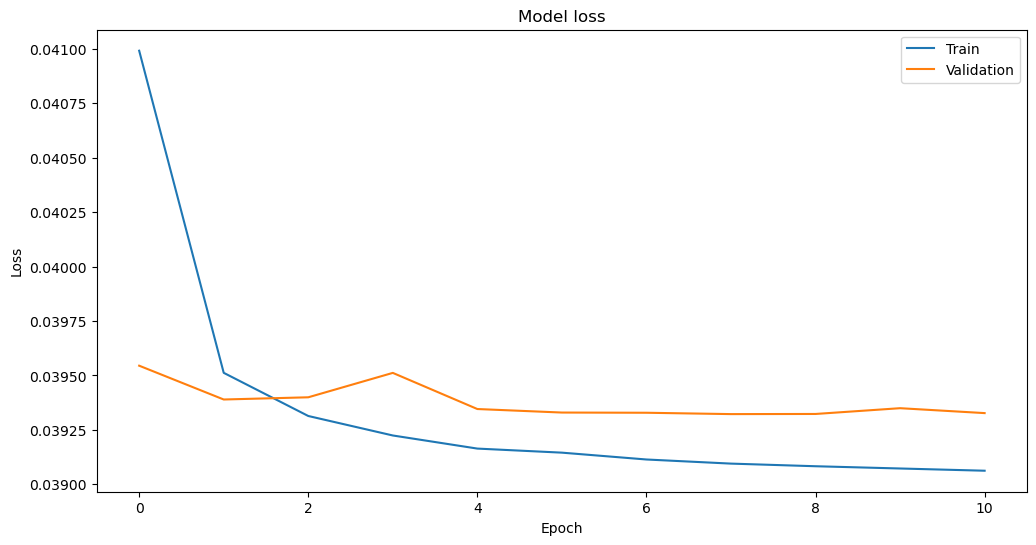

In [365]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

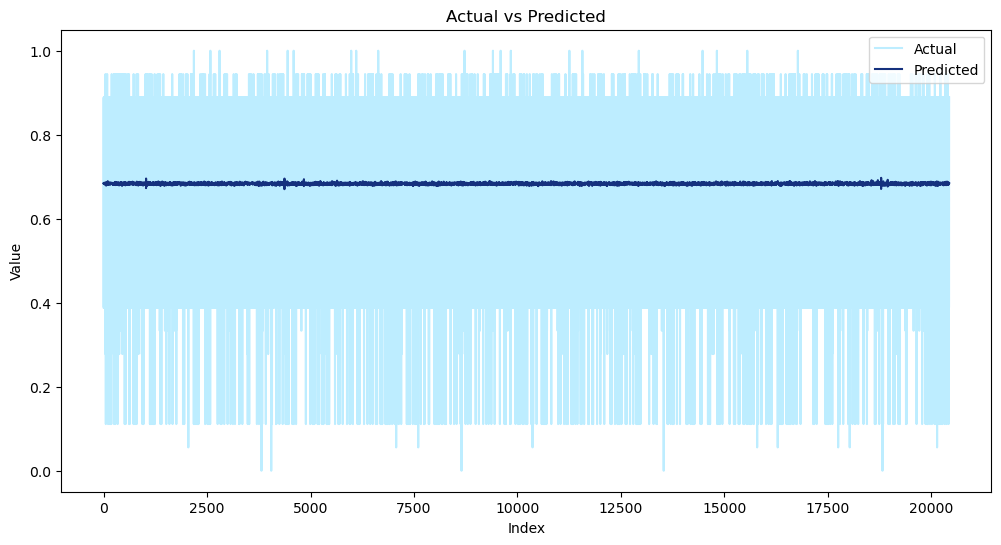

In [375]:
feature_idx = 5
plt.figure(figsize=(12,6))
plt.plot(y_test[:, feature_idx], color='#BDEDFF', label='Actual')
plt.plot(predictions[:, feature_idx], color='#15317E', label='Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Value')
plt.xlabel('Index')
plt.legend(loc='upper right')
plt.show()

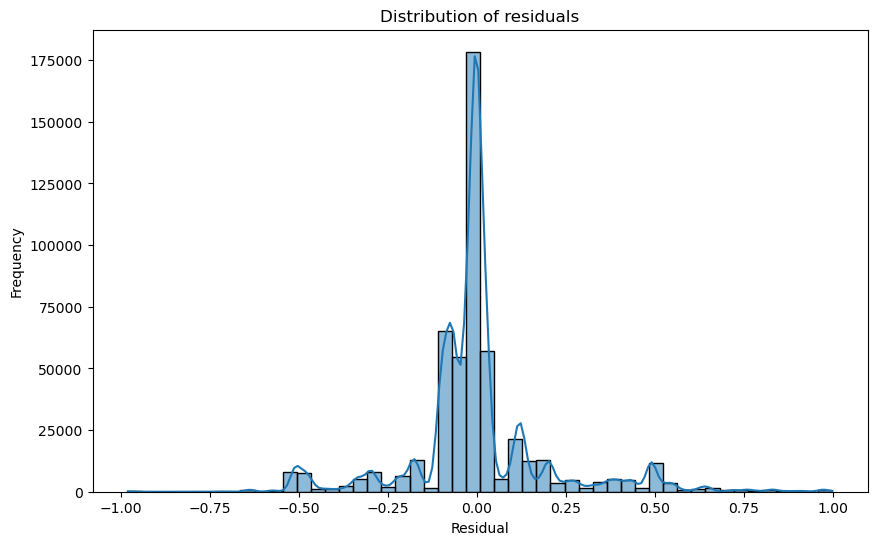

In [350]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals.flatten(), bins=50, kde=True)
plt.title('Distribution of residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

#### Supervised Approach

In [351]:
# Reading Labeled Data
df = pd.read_pickle("my_labeled_data.pkl")
# Prepare data
X = df.drop(columns=['anomaly'])
y = df['anomaly']
#normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # return_sequences=True for stacking
model.add(Dropout(0.2))
model.add(LSTM(30, activation='relu'))  # Additional LSTM layer
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
# Make predictions
y_pred = model.predict(X_test)
# Convert probabilities into class labels
y_pred = np.where(y_pred > 0.5, 1, 0)
# Print classification report
print(classification_report(y_test, y_pred))
# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

Epoch 1/100
409/409 [==============================] - 5s 6ms/step - loss: 0.1439 - accuracy: 0.9855 - val_loss: 0.0628 - val_accuracy: 0.9847
Epoch 2/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0575 - accuracy: 0.9875 - val_loss: 0.0556 - val_accuracy: 0.9847
Epoch 3/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0501 - accuracy: 0.9875 - val_loss: 0.0471 - val_accuracy: 0.9847
Epoch 4/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0454 - accuracy: 0.9876 - val_loss: 0.0418 - val_accuracy: 0.9850
Epoch 5/100
409/409 [==============================] - 2s 5ms/step - loss: 0.0389 - accuracy: 0.9894 - val_loss: 0.0360 - val_accuracy: 0.9890
Epoch 6/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0331 - accuracy: 0.9903 - val_loss: 0.0331 - val_accuracy: 0.9899
Epoch 7/100
409/409 [==============================] - 2s 5ms/step - loss: 0.0309 - accuracy: 0.9915 - val_loss: 0.0304 - val_accuracy: 0.9902

#####  Results

In [352]:
# precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Precision: 0.96875
Recall: 0.62
F1-Score: 0.7560975609756097
True Positives: 31
True Negatives: 4040
False Positives: 1
False Negatives: 19


#####  Visualizations

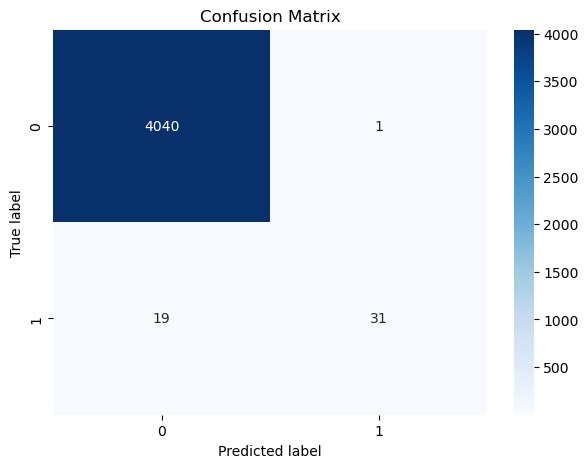

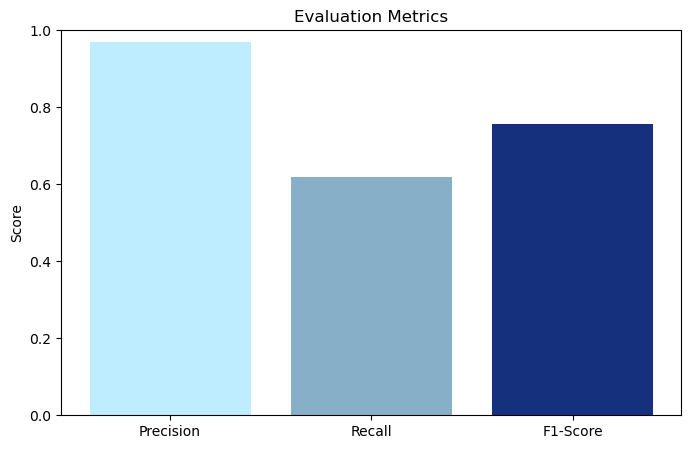

In [353]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
plt.figure(figsize=(8, 5))
plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1], color=['#BDEDFF', '#87AFC7', '#15317E'])
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim([0.0, 1.0])
plt.show()



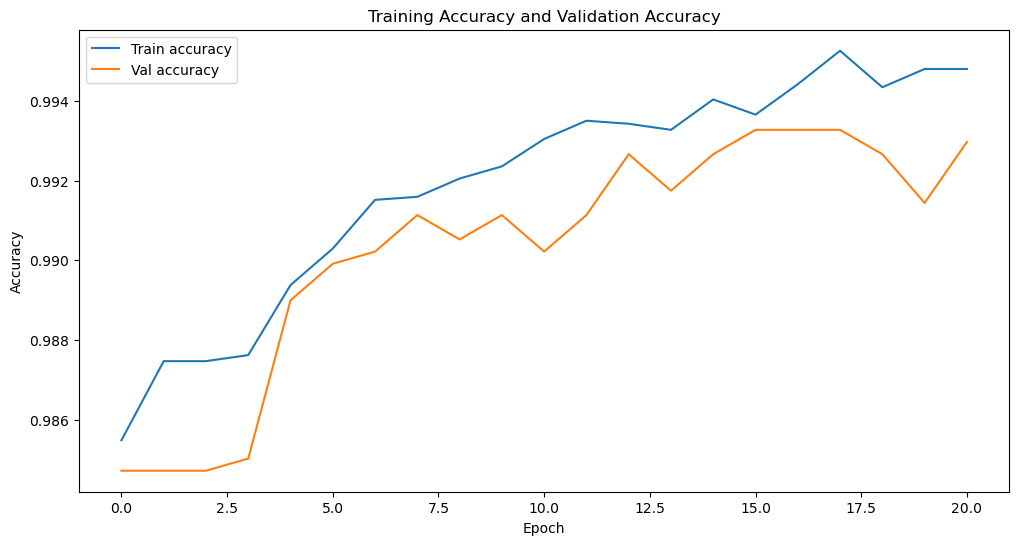

In [354]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()